
Performance Metrics for S&P 500:
Sharpe Ratio (S&P 500): 0.6062135406788131
Sortino Ratio (S&P 500): 0.7377562229076915
Max Drawdown (S&P 500): 15.206271820448931

Percentage Returns for S&P 500:
S&P 500 Percentage Return: 1.383044413195916
Stacking Model Accuracy: 0.9899665551839465

Backtesting Metrics:
1. Gross Profit: -0.35396117818346606
2. Net Profit: 5.150473504471788
3. Total Closed Trades: 30
4. Win Rate (Profitability %): 0.2781501340482574
5. Max Drawdown: 0.8534945461565945
6. Gross Loss: 0.0
7. Average Winning Trade (in USDT): 0.055756597285614454
8. Average Losing Trade (in USDT): -0.05052953474454553
9. Buy and Hold Return of BTC: 2.2157059237057495
10. Largest Losing Trade (in USDT): -0.28171361453537824
11. Largest Winning Trade (in USDT): 0.3749294753587131
12. Sharpe Ratio: 1.0211381467339988
13. Sortino Ratio: 1.1213979282532724
14. Average Holding Duration per Trade: 52.69520103761349
15. Max Dip and Average Dip in Running Trade:
Max Dip: 0.8534945461565945
Averag

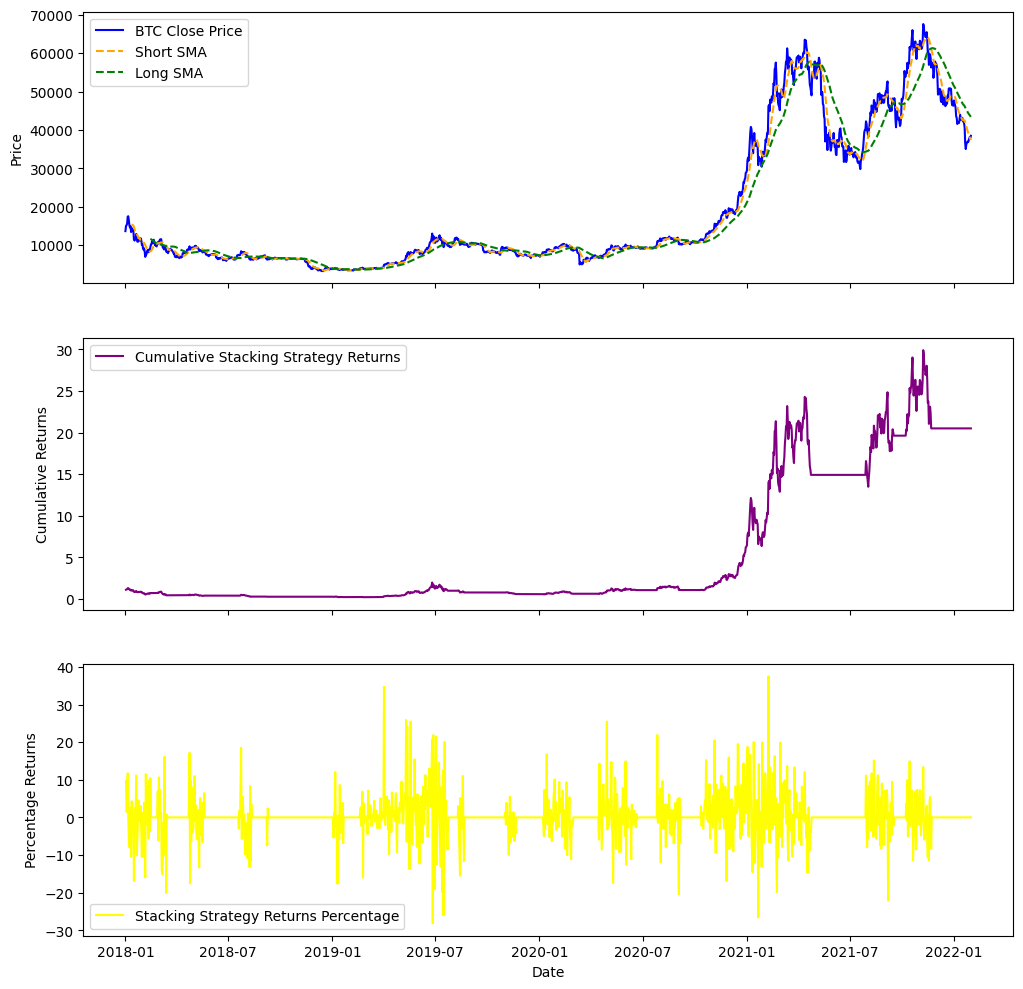

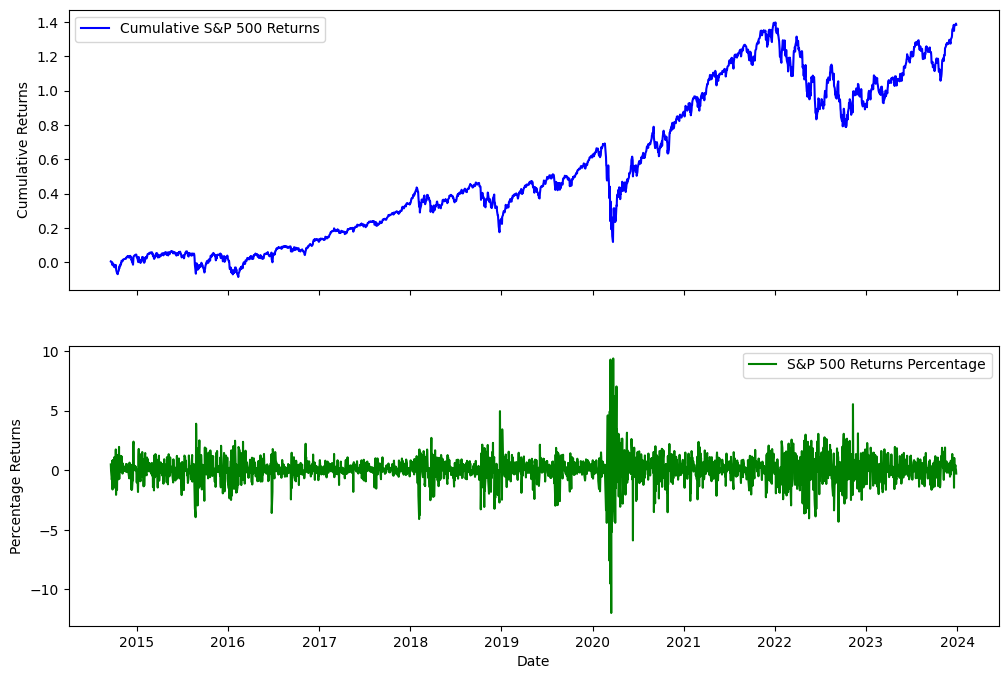

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, log_loss
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load BTC data
# btc_data = pd.read_csv(btc_file_path)
btc_data = pd.read_csv('BTC-USD2.csv')
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
btc_data.set_index('Date', inplace=True)

# Load S&P 500 historical data
# sp500_data = pd.read_csv(sp500_file_path)
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
sp500_data.set_index('Date', inplace=True)

# Calculate S&P 500 returns
sp500_data['sp500_returns_percentage'] = sp500_data['Adj Close'].pct_change() * 100

# Calculate cumulative S&P 500 returns
sp500_data['cumulative_sp500_returns'] = (1 + sp500_data['sp500_returns_percentage'] / 100).cumprod() - 1

# Calculate performance metrics for S&P 500
sp500_sharpe_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_sortino_ratio = (sp500_data['sp500_returns_percentage'].mean() / sp500_data[sp500_data['sp500_returns_percentage'] < 0]['sp500_returns_percentage'].std()) * np.sqrt(252)
sp500_max_drawdown = -(sp500_data['cumulative_sp500_returns'] / sp500_data['cumulative_sp500_returns'].cummax() - 1).min()

# Print performance metrics for S&P 500
print("\nPerformance Metrics for S&P 500:")
print("Sharpe Ratio (S&P 500):", sp500_sharpe_ratio)
print("Sortino Ratio (S&P 500):", sp500_sortino_ratio)
print("Max Drawdown (S&P 500):", sp500_max_drawdown)

# Print Percentage Returns for S&P 500
sp500_percentage_return = sp500_data['Adj Close'].iloc[-1] / sp500_data['Adj Close'].iloc[0] - 1
print("\nPercentage Returns for S&P 500:")
print("S&P 500 Percentage Return:", sp500_percentage_return)

# Calculate additional indicators
btc_data['sma_short'] = btc_data['Close'].rolling(window=12).mean()
btc_data['sma_long'] = btc_data['Close'].rolling(window=45).mean()

# Generate signals based on moving average crossover
btc_data['buy_signal'] = np.where(btc_data['sma_short'] > btc_data['sma_long'], 1, 0)
btc_data['sell_signal'] = np.where(btc_data['sma_short'] < btc_data['sma_long'], -1, 0)
btc_data['position'] = btc_data['buy_signal'] + btc_data['sell_signal']

# Prepare features and target for machine learning model
features = btc_data[['sma_short', 'sma_long']]
target = btc_data['position']

# Convert target to [0, 1, 2]
target_classes = [-1, 0, 1]
btc_data['position'] = btc_data['position'].apply(lambda x: target_classes.index(x))

# Prepare features and target for machine learning model
features = btc_data[['sma_short', 'sma_long']]
target = btc_data['position']

# Impute NaN values in features
imputer = SimpleImputer(strategy='mean')
features_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

# Split data for machine learning model
X_train, X_test, y_train, y_test = train_test_split(features_imputed, target, test_size=0.2, random_state=42)

# Tune XGBoost hyperparameters
# param_grid = {
#     'n_estimators': [100, 500, 1000],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 1, 2]
# }
param_grid = {
    'n_estimators': [500, 1000, 7900],
    'learning_rate': [0.756, 0.8, 0.98],
    'max_depth': [4, 6, 11],
    'subsample': [0.8, 0.9, 0.8],
    'colsample_bytree': [0.8, 0.9, 0.8],
    'gamma': [0, 2, 1]
}


custom_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=TimeSeriesSplit(n_splits=5), scoring=custom_scorer)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Use stacking with XGBoost, Random Forest, and Logistic Regression
estimators = [
    ('xgb', XGBClassifier(random_state=42, **grid_search.best_params_)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]

stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(random_state=42))

stacking_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_classifier.predict(X_test)

# Evaluate the stacking model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Model Accuracy: {accuracy_stacking}")

# Implement strategy based on stacking predictions
btc_data['stacking_signal'] = stacking_classifier.predict(features_imputed)

btc_data['returns'] = btc_data['Close'].pct_change()

# Backtest the stacking strategy
btc_data['stacking_strategy_returns'] = btc_data['stacking_signal'].shift(1) * btc_data['returns']
btc_data['cumulative_stacking_strategy_returns'] = (1 + btc_data['stacking_strategy_returns']).cumprod()

# Calculate additional performance metrics for stacking
stacking_sharpe_ratio = (btc_data['stacking_strategy_returns'].mean() / btc_data['stacking_strategy_returns'].std()) * np.sqrt(252)
stacking_sortino_ratio = (btc_data['stacking_strategy_returns'].mean() / btc_data[btc_data['stacking_strategy_returns'] < 0]['stacking_strategy_returns'].std()) * np.sqrt(252)
stacking_max_drawdown = -(btc_data['cumulative_stacking_strategy_returns'] / btc_data['cumulative_stacking_strategy_returns'].cummax() - 1).min()

# Additional requested metrics
gross_profit = btc_data.loc[btc_data['stacking_signal'] == 1, 'returns'].sum()
net_profit = btc_data['stacking_strategy_returns'].sum()
total_closed_trades = btc_data['stacking_signal'].diff().ne(0).sum()
win_rate = (btc_data['stacking_strategy_returns'] > 0).mean()
gross_loss = btc_data.loc[btc_data['stacking_signal'] == -1, 'returns'].sum()
average_winning_trade = btc_data.loc[btc_data['stacking_strategy_returns'] > 0, 'stacking_strategy_returns'].mean()
average_losing_trade = btc_data.loc[btc_data['stacking_strategy_returns'] < 0, 'stacking_strategy_returns'].mean()
buy_and_hold_return = btc_data['returns'].cumsum().iloc[-1]
largest_losing_trade = btc_data['stacking_strategy_returns'].min()
largest_winning_trade = btc_data['stacking_strategy_returns'].max()
average_holding_duration_per_trade = btc_data.loc[btc_data['stacking_signal'] != 0, 'stacking_signal'].apply(lambda x: 1).groupby(btc_data['stacking_signal'].eq(0).cumsum()).cumsum().mean()
max_dip_running_trade = -(btc_data['cumulative_stacking_strategy_returns'] / btc_data['cumulative_stacking_strategy_returns'].cummax() - 1).min()
average_dip_running_trade = -(btc_data['cumulative_stacking_strategy_returns'] / btc_data['cumulative_stacking_strategy_returns'].cummax() - 1).mean()

# Display requested metrics
print("\nBacktesting Metrics:")
print("1. Gross Profit:", gross_profit)
print("2. Net Profit:", net_profit)
print("3. Total Closed Trades:", total_closed_trades)
print("4. Win Rate (Profitability %):", win_rate)
print("5. Max Drawdown:", stacking_max_drawdown)  # Use the stacking_max_drawdown calculated earlier
print("6. Gross Loss:", gross_loss)
print("7. Average Winning Trade (in USDT):", average_winning_trade)
print("8. Average Losing Trade (in USDT):", average_losing_trade)
print("9. Buy and Hold Return of BTC:", buy_and_hold_return)
print("10. Largest Losing Trade (in USDT):", largest_losing_trade)
print("11. Largest Winning Trade (in USDT):", largest_winning_trade)
print("12. Sharpe Ratio:", stacking_sharpe_ratio)  # Use the stacking_sharpe_ratio calculated earlier
print("13. Sortino Ratio:", stacking_sortino_ratio)  # Use the stacking_sortino_ratio calculated earlier
print("14. Average Holding Duration per Trade:", average_holding_duration_per_trade)
print("15. Max Dip and Average Dip in Running Trade:")
print("Max Dip:", max_dip_running_trade)
print("Average Dip:", average_dip_running_trade)

# Print Percentage Returns for BTC
btc_percentage_return = btc_data['Close'].iloc[-1] / btc_data['Close'].iloc[0] - 1
print("\nPercentage Returns for BTC:")
print("BTC Percentage Return:", btc_percentage_return)

# Display the Stacking Signal and Returns for BTC
print("\nStacking Signals and Returns for BTC:")
print(btc_data[['stacking_signal', 'stacking_strategy_returns']])

# Plot Results for BTC
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Plot BTC Close Price and SMAs
ax1.plot(btc_data.index, btc_data['Close'], label='BTC Close Price', color='blue')
ax1.plot(btc_data.index, btc_data['sma_short'], label='Short SMA', color='orange', linestyle='--')
ax1.plot(btc_data.index, btc_data['sma_long'], label='Long SMA', color='green', linestyle='--')
ax1.set_ylabel('Price')
ax1.legend()

# Plot Cumulative Stacking Strategy Returns
ax2.plot(btc_data.index, btc_data['cumulative_stacking_strategy_returns'], label='Cumulative Stacking Strategy Returns', color='purple')
ax2.set_ylabel('Cumulative Returns')
ax2.legend()

# Plot Percentage Returns for Stacking Strategy (Now in yellow)
ax3.plot(btc_data.index, btc_data['stacking_strategy_returns'] * 100, label='Stacking Strategy Returns Percentage', color='yellow')
ax3.set_xlabel('Date')
ax3.set_ylabel('Percentage Returns')
ax3.legend()

plt.show()

# Plot Results for S&P 500
fig2, (ax4, ax5) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Cumulative Returns for S&P 500
ax4.plot(sp500_data.index, sp500_data['cumulative_sp500_returns'], label='Cumulative S&P 500 Returns', color='blue')
ax4.set_ylabel('Cumulative Returns')
ax4.legend()

# Plot Percentage Returns for S&P 500
ax5.plot(sp500_data.index, sp500_data['sp500_returns_percentage'], label='S&P 500 Returns Percentage', color='green')
ax5.set_xlabel('Date')
ax5.set_ylabel('Percentage Returns')
ax5.legend()

plt.show()
